In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision
from VAE.vae_v2 import VAE

In [19]:
# --- Гиперпараметры ---
BATCH_SIZE = 128
LATENT_DIM = 64
IMAGE_SIZE = 256  # Можно менять: 64, 128, 256 (должно делиться на 16)

EPOCHS = 500
LEARNING_RATE = 1e-3
SAVE_PATH = './models/vae_model_V-3.pth'
OLD_MODEL = False  # Указать путь к модели для загрузки, если нужно
OUTPUT = './output'
#OLD_MODEL = SAVE_PATH

In [3]:
# --- Устройство ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# --- Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [5]:
dataset = datasets.ImageFolder(root='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Loaded {len(dataset)} images from 'data'")

Loaded 1800 images from 'data'


In [6]:
# --- Функция потерь ---
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [7]:
# --- Функции для визуализации ---
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение потерь')
    plt.title('График изменения потерь в процессе обучения')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 24))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [8]:
# --- Инициализация и загрузка модели ---
vae = VAE(LATENT_DIM, IMAGE_SIZE).to(device)

if OLD_MODEL:
    print(f"Loading model from {OLD_MODEL}")
    vae.load_state_dict(torch.load(OLD_MODEL, map_location=device))
    print("Model loaded successfully.")

optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

In [9]:
# --- Обучение ---
losses = []
for epoch in range(EPOCHS):
    vae.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] - Training Loss: {avg_loss:.4f}')

Epoch [1/100] - Training Loss: 38493.3360
Epoch [2/100] - Training Loss: 8433.5135
Epoch [3/100] - Training Loss: 5113.5532
Epoch [4/100] - Training Loss: 4119.9552
Epoch [5/100] - Training Loss: 3707.6674
Epoch [6/100] - Training Loss: 3438.9914
Epoch [7/100] - Training Loss: 3133.4677
Epoch [8/100] - Training Loss: 2774.7457
Epoch [9/100] - Training Loss: 2518.0480
Epoch [10/100] - Training Loss: 2340.9763
Epoch [11/100] - Training Loss: 2217.7391
Epoch [12/100] - Training Loss: 2106.4989
Epoch [13/100] - Training Loss: 1964.4341
Epoch [14/100] - Training Loss: 1917.1878
Epoch [15/100] - Training Loss: 1824.2193
Epoch [16/100] - Training Loss: 1712.6909
Epoch [17/100] - Training Loss: 1672.2009
Epoch [18/100] - Training Loss: 1608.9154
Epoch [19/100] - Training Loss: 1563.8842
Epoch [20/100] - Training Loss: 1507.8058
Epoch [21/100] - Training Loss: 1462.9098
Epoch [22/100] - Training Loss: 1450.2754
Epoch [23/100] - Training Loss: 1406.7241
Epoch [24/100] - Training Loss: 1351.0906


In [10]:
# --- Сохранение модели ---
torch.save({
        "model": vae.state_dict(),
        "BATCH_SIZE": BATCH_SIZE,
        "LATENT_DIM":LATENT_DIM,
        "IMAGE_SIZE":IMAGE_SIZE,
        "v":2
    }, SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")

Model saved to ./models/vae_model_V-3.pth


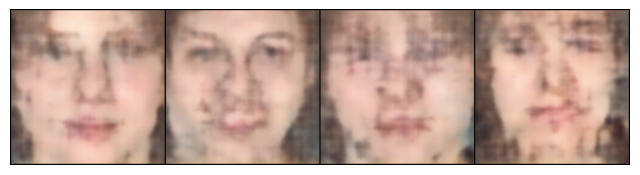

Generated faces saved to f'{OUTPUT}/generated_faces.png'


In [13]:
# --- Генерация новых лиц ---

NUM_PIC = 4

vae.eval()
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(device)
    samples = vae.decoder(z)
imshow(torchvision.utils.make_grid(samples.cpu()))
vutils.save_image(samples.cpu(), f'{OUTPUT}/generated_faces.png', nrow=4)
print("Generated faces saved to f'{OUTPUT}/generated_faces.png'")

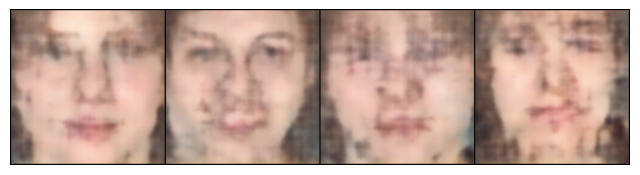

In [14]:

imshow(torchvision.utils.make_grid(samples.cpu()))


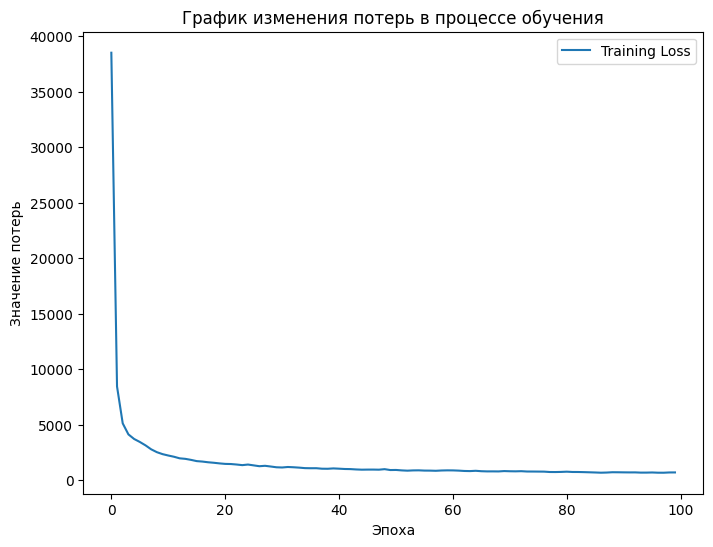

In [15]:
# --- Визуализация графика потерь ---
plot_loss(losses)

In [20]:
# --- Уведомление о завершении обучения ---
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение автоэнкодера завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")


Notification sent! Status Code: 200 | Response Text: SENDING


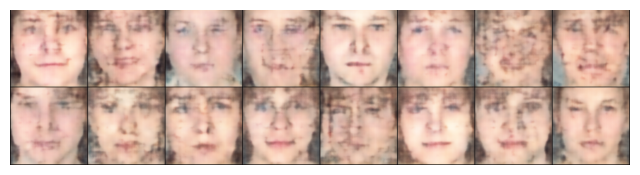

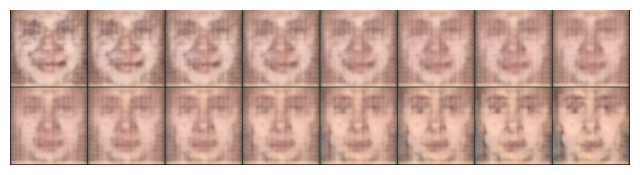

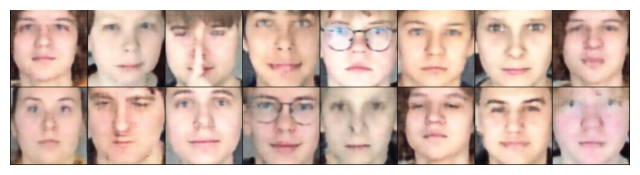

C:\Users\teacher\AppData\Local\Temp\1\ipykernel_17612\3340395165.py:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_path))


GIF морфинга сохранён как 'morphing.gif'


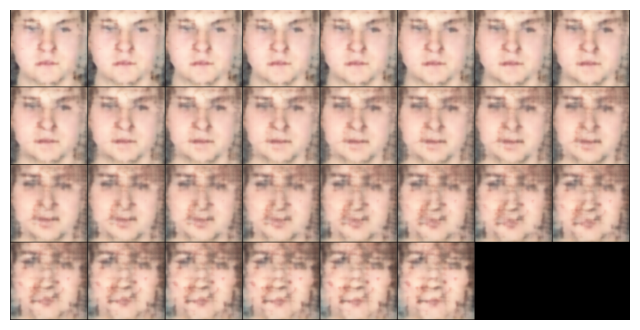

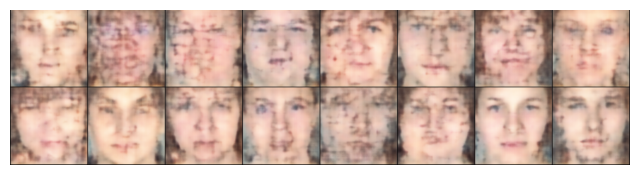

In [21]:
# Продолжение для работы с обученным VAE
# Генерация разных типов z для декодера и создание GIF морфинга

import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import imageio

# --- Функции визуализации ---
def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Настройки ---
NUM_PIC = 16  # Количество изображений
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагаем, что модель уже загружена как "vae"
vae.eval()

# Папка для сохранения промежуточных картинок
os.makedirs('morph_frames', exist_ok=True)

# --- 1. Стандартное сэмплирование (N(0,1)) ---
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{OUTPUT}/z_random_normal.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 2. Ручное задание признаков ---
with torch.no_grad():
    z = torch.zeros(NUM_PIC, LATENT_DIM).to(DEVICE)
    z[:, :2] = torch.linspace(-3, 3, NUM_PIC).unsqueeze(1).repeat(1, 2)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{OUTPUT}/z_manual_features.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 3. Латентные коды реальных изображений ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

with torch.no_grad():
    mu, logvar = vae.encoder(real_imgs)
    z = vae.reparameterize(mu, logvar)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{OUTPUT}/z_from_real_imgs.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

# --- 4. Интерполяция между двумя точками ---
frames = []
with torch.no_grad():
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    alphas = torch.linspace(0, 1, steps=30).unsqueeze(1).to(DEVICE)
    z = (1 - alphas) * z1 + alphas * z2
    for i, zi in enumerate(z):
        sample = vae.decoder(zi.unsqueeze(0))
        img_path = f'{OUTPUT}/morph_frames/frame_{i:03d}.png'
        vutils.save_image(sample.cpu(), img_path, nrow=1)
        frames.append(imageio.imread(img_path))
    imageio.mimsave(f'{OUTPUT}/morphing.gif', frames, fps=10)
    print("GIF морфинга сохранён как 'morphing.gif'")

# Показываем последний батч интерполяции
vutils.save_image(vae.decoder(z).cpu(), f'{OUTPUT}/z_interpolation.png', nrow=6)
imshow(torchvision.utils.make_grid(vae.decoder(z).cpu()))

# --- 5. Альтернативное распределение (равномерное) ---
with torch.no_grad():
    z = torch.empty(NUM_PIC, LATENT_DIM).uniform_(-2, 2).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{OUTPUT}/z_uniform_distribution.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))


Сетка лиц сохранена в ./output/grid_faces_0_1.png


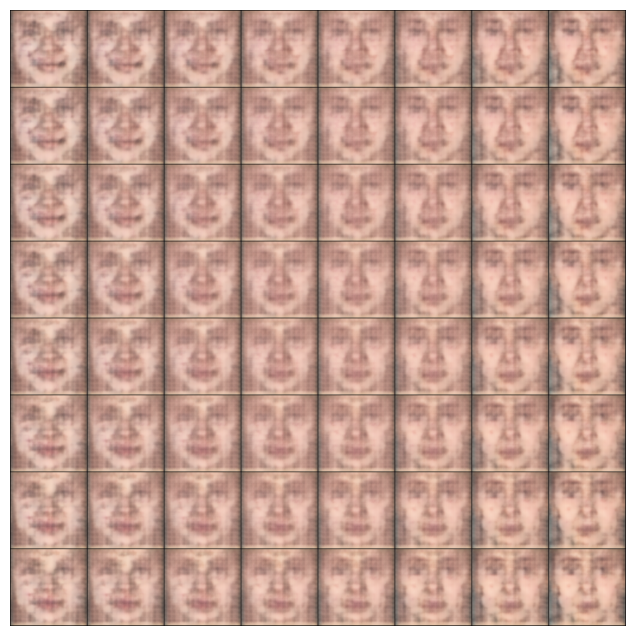

Сетка лиц сохранена в ./output/grid_faces_2_3.png


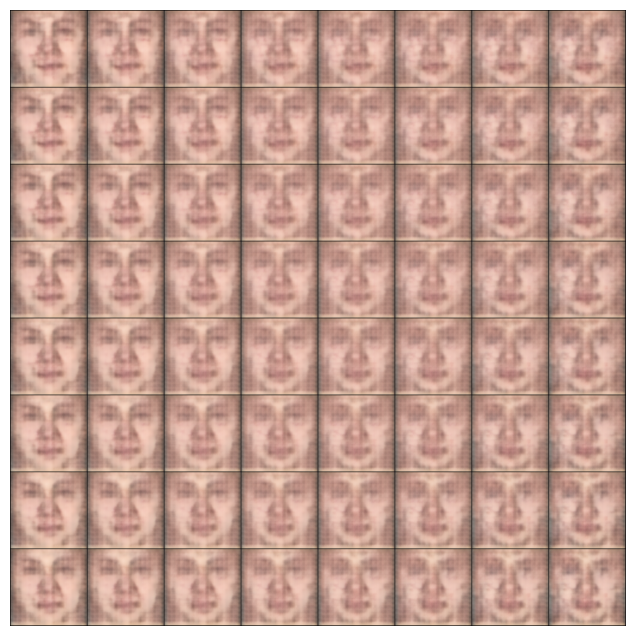

Сетка лиц сохранена в ./output/grid_faces_5_6.png


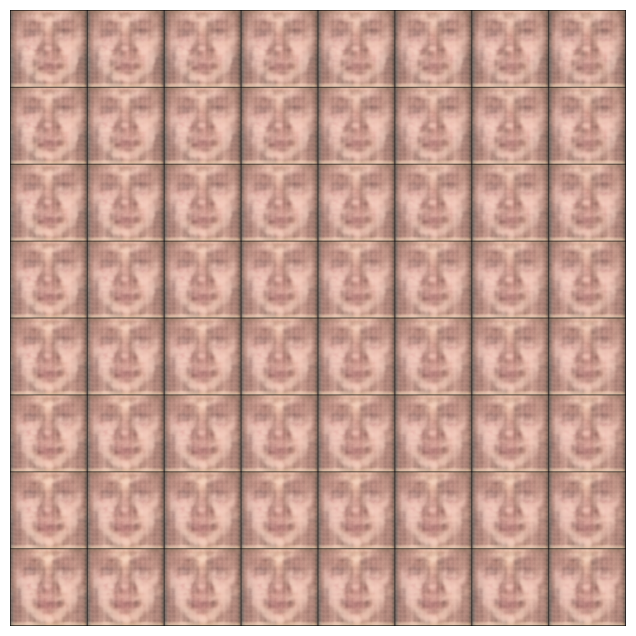

C:\Users\teacher\AppData\Local\Temp\1\ipykernel_17612\4262018350.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(img_path))


Анимация латентного перехода сохранена в latent_walk.gif


In [22]:
# Код для удобного подбора ручных признаков и генерации 2D-сетки лиц + анимация

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import os
import imageio

# --- Настройки ---

GRID_SIZE = 8  # Сетка GRID_SIZE x GRID_SIZE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Предполагаем, что модель VAE уже загружена и называется "vae"
vae.eval()

# --- Удобный подбор параметров ---
def generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3, grid_size=GRID_SIZE):
    total = grid_size * grid_size
    z = torch.full((total, LATENT_DIM), fixed_value).to(DEVICE)
    values = torch.linspace(range_min, range_max, steps=grid_size)
    grid = torch.cartesian_prod(values, values)
    for idx, (val_x, val_y) in enumerate(grid):
        z[idx, vary_dims[0]] = val_x
        z[idx, vary_dims[1]] = val_y
    return z

# --- Генерация 2D-сетки лиц ---
def generate_face_grid(z, save_path=f'{OUTPUT}/grid_faces.png', grid_size=GRID_SIZE):
    with torch.no_grad():
        samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), save_path, nrow=grid_size)
    print(f"Сетка лиц сохранена в {save_path}")
    imshow(torchvision.utils.make_grid(samples.cpu(), nrow=grid_size))

# --- Функция отображения изображений ---
def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# --- Анимация перемещения по латентному пространству ---
def generate_latent_animation(vary_dims=(0, 1), steps=30, fixed_value=0.0, range_min=-3, range_max=3, save_path='latent_walk.gif'):
    frames = []
    os.makedirs('latent_frames', exist_ok=True)
    with torch.no_grad():
        for step in range(steps):
            alpha = step / (steps - 1)
            val_x = (1 - alpha) * range_min + alpha * range_max
            val_y = np.sin(alpha * np.pi * 2) * (range_max / 2)

            z = torch.full((1, LATENT_DIM), fixed_value).to(DEVICE)
            z[0, vary_dims[0]] = val_x
            z[0, vary_dims[1]] = val_y

            sample = vae.decoder(z)
            img_path = f'{OUTPUT}/latent_frames/frame_{step:03d}.png'
            vutils.save_image(sample.cpu(), img_path, nrow=1)
            frames.append(imageio.imread(img_path))

    imageio.mimsave(save_path, frames, fps=10)
    print(f"Анимация латентного перехода сохранена в {save_path}")

# --- Примеры использования ---

# 1. Меняем 0-й и 1-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3)
generate_face_grid(z, save_path=f'{OUTPUT}/grid_faces_0_1.png')

# 2. Меняем 2-й и 3-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(2, 3), range_min=-2, range_max=2)
generate_face_grid(z, save_path=f'{OUTPUT}/grid_faces_2_3.png')

# 3. Узкий диапазон изменений для тонких вариаций
z = generate_manual_z(fixed_value=0.0, vary_dims=(5, 6), range_min=-1, range_max=1)
generate_face_grid(z, save_path=f'{OUTPUT}/grid_faces_5_6.png')

# 4. Генерация анимации перемещения по латентному пространству
generate_latent_animation(vary_dims=(0, 1), steps=40, save_path='latent_walk.gif')
